# Модель 24

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Импорт необходимых библиотек

In [14]:
!pip install tensorflow-addons
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
%cd drive/MyDrive/YaMlProject/models/models

[Errno 2] No such file or directory: 'drive/MyDrive/YaMlProject/models/models'
/content/drive/MyDrive/YaMlProject/models/models


In [16]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import tensorflow as tf
import tensorflow_addons as tfa
import torchvision as tv
from PIL import Image
from livelossplot import PlotLossesKeras
from sklearn.metrics import confusion_matrix

sys.path.append('../../')

from core.datasets import get_ds
from core.make_answer import make_ans_file

#### Формируем аугментацию.

##### Вариант 1.

- Пишите аугментацию. Объект класса tv.transforms.Compose или tv.transforms.{аугментация}

In [17]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-12, 12), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

#### Создаем датасеты
```python
get_ds(
    file_train, `Путь к трейновому датасету`
    file_test, `Путь к тестовому датасету`
    transform=None,  `Аугументация`
    batch_size=512,  `Размер батча`
    one_hot=False,  `Формат ответов one_hot_encoding или нет`
    val_size=0.03,  `Размер валидационного датасета, относительно data_train`
    back=1,  `На сколько уровней в директории надо подняться наверх, чтобы дойти до корневой`
)
```

Позже мы будем делать ансамбли и похожие эвристики, поэтому всегда делайте `one_hot=True`

In [18]:
train_ds, val_ds, test_ds = get_ds('smote_data_train_7000', 'repaired_data_test', transform=transformer,
                                   one_hot=True, back=2, batch_size=100)

Для дальнейшей проверки метрик разделяем валидационный датасет на x и y

In [19]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

Смотрим на получившуюся агументацию.

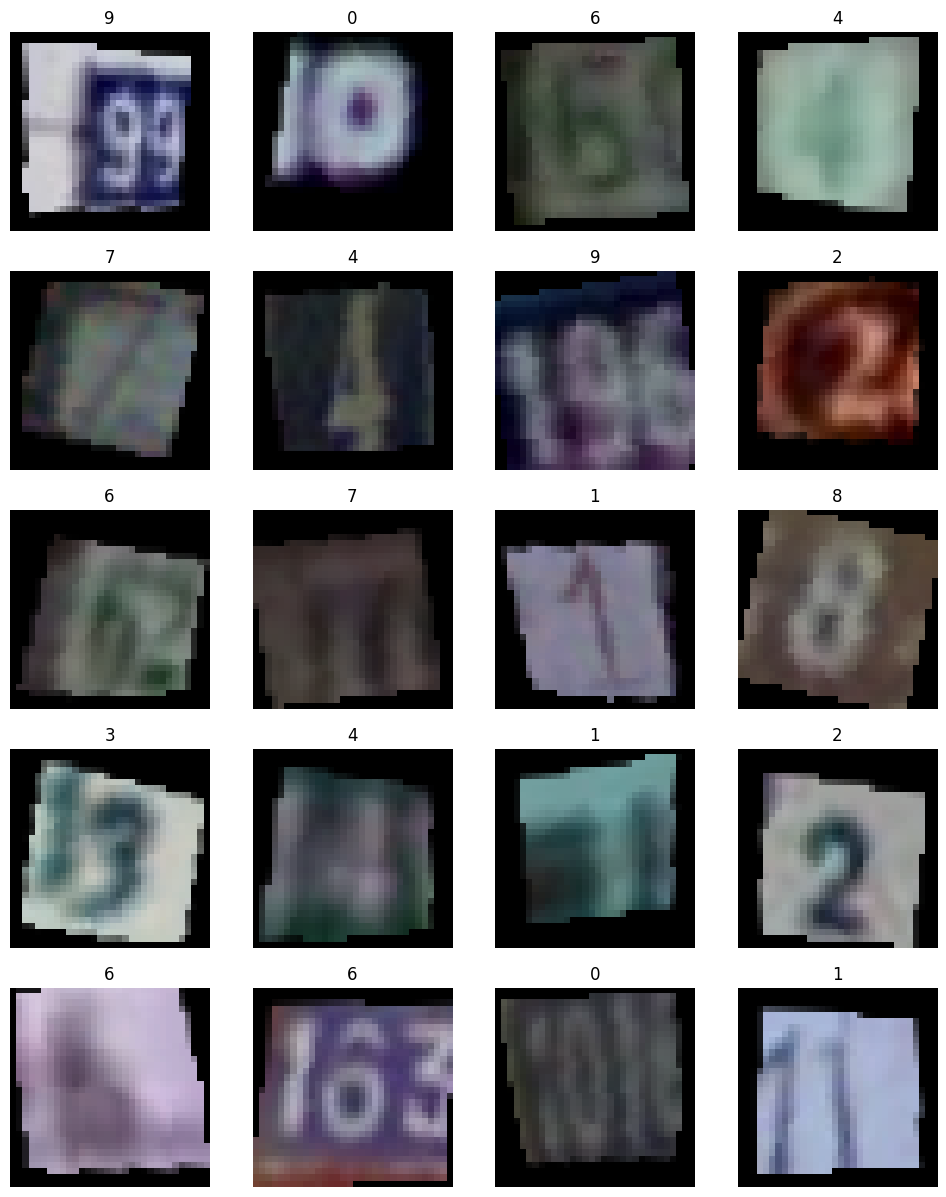

In [20]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(np.argmax(train_ds_visualization[1][i]))
    plt.axis('off')
plt.show()

In [21]:
train_ds_visualization[1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

#### Пишем модель

Про свертки и пуллинги написано у Гриши, про skip-connection написано у Миши

Для правильного использования ансамблирования, в финальном слое не пишем функцию активации. Подробнее написано у Дениса.

код для создания блока

In [22]:
def get_block(input_, filters, t, stride):
    in_ = input_.shape[-1]

    x = tf.keras.layers.Conv2D(in_ * t, 1, strides=1, padding='same', use_bias=False)(input_)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6)(x)

    x = tf.keras.layers.DepthwiseConv2D(3, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6)(x)

    x = tf.keras.layers.Conv2D(filters, 1, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    return x if in_ != filters else tf.keras.layers.Add()([input_, x])

код модели

In [23]:
model_input = tf.keras.Input(shape=(32, 32, 3), batch_size=100)

x = tf.keras.layers.Conv2D(32, 3, strides=1, padding='same', use_bias=False)(model_input)

x = get_block(x, 16, 1, 1)

x = get_block(x, 24, 6, 1)
x = get_block(x, 24, 6, 1)

x = get_block(x, 32, 6, 1)
x = get_block(x, 32, 6, 1)
x = get_block(x, 32, 6, 1)

x = get_block(x, 64, 6, 2)
x = get_block(x, 64, 6, 1)
x = get_block(x, 64, 6, 1)

x = tf.keras.layers.Dropout(0.2)(x)

x = get_block(x, 96, 6, 1)
x = get_block(x, 96, 6, 1)

x = tf.keras.layers.Dropout(0.2)(x)

x = get_block(x, 160, 6, 2)
x = get_block(x, 160, 6, 1)

x = tf.keras.layers.Dropout(0.2)(x)

x = get_block(x, 320, 6, 1)

x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(1280, 1, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(6)(x)

x = tf.keras.layers.GlobalMaxPool2D()(x)
x = tf.keras.layers.Dense(10)(x)

model = tf.keras.models.Model(inputs=model_input, outputs=x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(100, 32, 32, 3)]   0           []                               
                                                                                                  
 conv2d_30 (Conv2D)             (100, 32, 32, 32)    864         ['input_2[0][0]']                
                                                                                                  
 conv2d_31 (Conv2D)             (100, 32, 32, 32)    1024        ['conv2d_30[0][0]']              
                                                                                                  
 batch_normalization_43 (BatchN  (100, 32, 32, 32)   128         ['conv2d_31[0][0]']              
 ormalization)                                                                              

In [24]:
num_model = '_g_24'

#### Создаем чекпоинты (всем уже рассказал)
- Если лень, то просто копипаст того, что я написал ниже. НЕ ЗАБЫВАЕМ МЕНЯТЬ ПЕРЕМЕННУЮ `num_model`!!!

In [25]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),

    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    )
]

#### Компиляция модели
- Если будете что то менять, то только оптимизатор. Про оптимизаторы написано у Лизы.

In [26]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam(decay=1e-4)),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

#### Обучаем модель

In [27]:
history = model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

Epoch 1/100
651/651 [==============================] - 126s 167ms/step - loss: 2.0329 - categorical_accuracy: 0.3155 - f1_score: 0.3147 - val_loss: 0.8216 - val_categorical_accuracy: 0.7347 - val_f1_score: 0.7407
Epoch 2/100
651/651 [==============================] - 108s 165ms/step - loss: 0.5952 - categorical_accuracy: 0.8104 - f1_score: 0.8101 - val_loss: 0.3910 - val_categorical_accuracy: 0.8861 - val_f1_score: 0.8873
Epoch 3/100
651/651 [==============================] - 107s 165ms/step - loss: 0.4213 - categorical_accuracy: 0.8690 - f1_score: 0.8690 - val_loss: 0.2993 - val_categorical_accuracy: 0.9110 - val_f1_score: 0.9108
Epoch 4/100
651/651 [==============================] - 101s 155ms/step - loss: 0.3708 - categorical_accuracy: 0.8873 - f1_score: 0.8873 - val_loss: 0.3273 - val_categorical_accuracy: 0.9070 - val_f1_score: 0.9077
Epoch 5/100
651/651 [==============================] - 104s 160ms/step - loss: 0.3363 - categorical_accuracy: 0.8976 - f1_score: 0.8976 - val_loss: 

In [ ]:
import pickle

pickle.dump(history, open('./data/history_g_24', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

Подгружаем все чекпоинты

In [28]:
model_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_categorical_accuracy.h5')
model_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_f1_score.h5')
model_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_loss.h5')
model_avg_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5')
model_avg_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_f1_score.h5')
model_avg_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_loss.h5')

У нас поличилось три чекпоинта (три модели). Ниже указан код для получения ответов для всех чекпоинтов по валидационному датасету.

In [29]:
ans_val_categorical_accuracy = make_ans_file(model_categorical_acc, val_ds_x)
ans_val_f1_score = make_ans_file(model_f1_score, val_ds_x)
ans_val_loss = make_ans_file(model_loss, val_ds_x)
ans_val_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, val_ds_x)
ans_val_avg_f1_score = make_ans_file(model_avg_f1_score, val_ds_x)
ans_val_avg_loss = make_ans_file(model_avg_loss, val_ds_x)
anss = [ans_val_categorical_accuracy, ans_val_f1_score, ans_val_loss, ans_val_avg_categorical_accuracy,
        ans_val_avg_f1_score, ans_val_avg_loss]

154/154 [==============================] - 2s 7ms/step


Формируем валидационные ответы.

In [30]:
val_ds_y = np.argmax(val_ds_y, axis=1)

Сравниваем валидационные предикты каждого чекпоинта

In [31]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

чекпоинты 1 и 2 одинаковые
чекпоинты 4 и 5 одинаковые


`Все ответы разные, значит чекпоинты сохранили модель на разных эпохах. Если ответы будут одинковые, то вывод о чекпоинте делать не надо.`

- Денис пишет ансамблинг моделей. Когда он допишет, мы применим это для формирования ответа по трем получившимся моделям. То есть, если все чекпоинты разные, то мы будем делать средний ответ по трем предиктам.

В конце смотрим на метрики и делаем выводы о том, чем хороша эта модель. Какие классы она угадывает лучше/худше всего. Дописываем какую метрику показал kaggle.

In [32]:
class MulticlassClassificationMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.matrix_error = self.get_matrix_error()

    def get_matrix_error(self):
        self.class_types = np.unique([self.y_true, self.y_pred])
        TP, FN, FP, TN = [], [], [], []
        for class_type in self.class_types:
            TP.append(np.sum(np.logical_and(self.y_true == self.y_pred, self.y_true == class_type)))
            FN.append(np.sum(np.logical_and(self.y_true == class_type, self.y_pred != class_type)))
            FP.append(np.sum(np.logical_and(self.y_pred == class_type, self.y_true != class_type)))
            TN.append(np.sum(np.logical_and(self.y_pred != class_type, self.y_true != class_type)))
        return pd.DataFrame({
            'class_type': self.class_types,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        }).set_index('class_type')

    def accuracy(self):
        return np.sum(self.y_true == self.y_pred) / self.y_true.shape[0]

    def precision(self, averaging='macro'):
        if averaging == 'macro':
            precisions = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FP'])
            return np.mean(precisions.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FP'])

    def recall(self, averaging='macro'):
        if averaging == 'macro':
            recalls = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FN'])
            return np.mean(recalls.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FN'])

    def f1_score(self, averaging='macro'):
        if averaging == 'macro':
            reverse_r = (self.matrix_error['TP'] + self.matrix_error['FN']) / self.matrix_error['TP']
            reverse_p = (self.matrix_error['TP'] + self.matrix_error['FP']) / self.matrix_error['TP']
            f1_scores = 2 / (reverse_r + reverse_p)
            return np.mean(f1_scores.replace(np.nan, 0))
        elif averaging == 'micro':
            p = self.precision(averaging)
            r = self.recall(averaging)
            return 2 * p * r / (p + r)

    def metrics(self, averaging='macro'):
        return {
            'accuracy': self.accuracy(),
            'precision': self.precision(averaging),
            'recall': self.recall(averaging),
            'f1_score': self.f1_score(averaging),
        }

    def __str__(self):
        headers = {
            'selector': '*',
            'props': 'background-color: darkgreen; color: white; font-size: 12pt;',
        }
        che_super_mega_puper_visualization_of_cell = {
            'selector': 'td:hover',
            'props': 'background-color: green; color: white;',
        }
        display(
            self.matrix_error
            .style
            .set_table_styles([
                headers,
                che_super_mega_puper_visualization_of_cell,
            ])
            .set_properties(**{'background-color': 'lightgreen',
                               'color': 'black', 'font-size': '12pt'})
        )
        return ''

    def __repr__(self):
        return (
            f'MulticlassClassificationMetrics(class_types={self.class_types})'
            .replace("'", '').replace(',', ';'))

### Accuracy чекпоинт

In [33]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,500,4384,9,8
1,499,4383,10,9
2,467,4417,9,8
3,456,4419,5,21
4,460,4431,5,5
5,496,4381,13,11
6,484,4390,11,16
7,508,4374,13,6
8,478,4395,13,15


{'accuracy': 0.9789838808406448,
 'precision': 0.9790716511961417,
 'recall': 0.9790309542010437,
 'f1_score': 0.9790009467082392}

- $FP_1=15$. То есть, модель предсказала 15 раз 1, когда на самом деле там была не 1. Наверное модель плохо различает 1 и 7.
- $FN_1=15$. То есть, модель 15 раз ошиблась, когда угадывала 1.

Метрики более менее хоршие. Переобучения нет. Ставить модель на больше эпох нет смысла, потому что последние 50 эпох модель практически не меняла веса.

`Это не шаблон!!! Писать надо как сами посчитаете`

### Loss чекпоинт

In [34]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,498,4385,8,10
1,495,4383,10,13
2,462,4419,7,13
3,457,4416,8,20
4,459,4427,9,6
5,497,4375,19,10
6,487,4383,18,13
7,505,4374,13,9
8,471,4397,11,22


{'accuracy': 0.9757192409712303,
 'precision': 0.9758382686068947,
 'recall': 0.9758057771945838,
 'f1_score': 0.9757568580180009}

- $FN_1=28$.
- $FP_1=19$.
- $FP_2=18$.
- $FP_3=18$.
- $FN_3=16$.
- $FN_8=15$.

Модель очень плохо справляется с единицами. Так же можно сказать что 2 и 3 модель часто угадывает ложно.

Метрики хуже, чем у accuracy чекпоинта. Но все равно посмотрим, что скажут метрики kaggle.

### F1-score чекпоинт

In [35]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_f1_score)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,500,4384,9,8
1,499,4383,10,9
2,467,4417,9,8
3,456,4419,5,21
4,460,4431,5,5
5,496,4381,13,11
6,484,4390,11,16
7,508,4374,13,6
8,478,4395,13,15


{'accuracy': 0.9789838808406448,
 'precision': 0.9790716511961417,
 'recall': 0.9790309542010437,
 'f1_score': 0.9790009467082392}

- $FN_1=19$.
- $FP_2=19$.

Модель плохо справляется с единицами и двойками.

Метрики неплохие.

### Среднее скользящее по accuracy чекпоинт

In [36]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,501,4385,8,7
1,498,4383,10,10
2,466,4418,8,9
3,459,4416,8,18
4,459,4431,5,6
5,495,4380,14,12
6,488,4388,13,12
7,507,4373,14,7
8,479,4397,11,14


{'accuracy': 0.9793919608243216,
 'precision': 0.9795206290844616,
 'recall': 0.9794048248736946,
 'f1_score': 0.9794437402215974}

### Скользящее среднее по F1-score чекпоинт

In [37]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_f1_score)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,501,4385,8,7
1,498,4383,10,10
2,466,4418,8,9
3,459,4416,8,18
4,459,4431,5,6
5,495,4380,14,12
6,488,4388,13,12
7,507,4373,14,7
8,479,4397,11,14


{'accuracy': 0.9793919608243216,
 'precision': 0.9795206290844616,
 'recall': 0.9794048248736946,
 'f1_score': 0.9794437402215974}

### Скользящее среднее по Loss чекпоинт

In [38]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,502,4383,10,6
1,498,4382,11,10
2,466,4410,16,9
3,460,4416,8,17
4,458,4431,5,7
5,495,4380,14,12
6,486,4385,16,14
7,506,4375,12,8
8,474,4400,8,19


{'accuracy': 0.9779636808814528,
 'precision': 0.9781084759385239,
 'recall': 0.97798751379768,
 'f1_score': 0.9780167956035672}

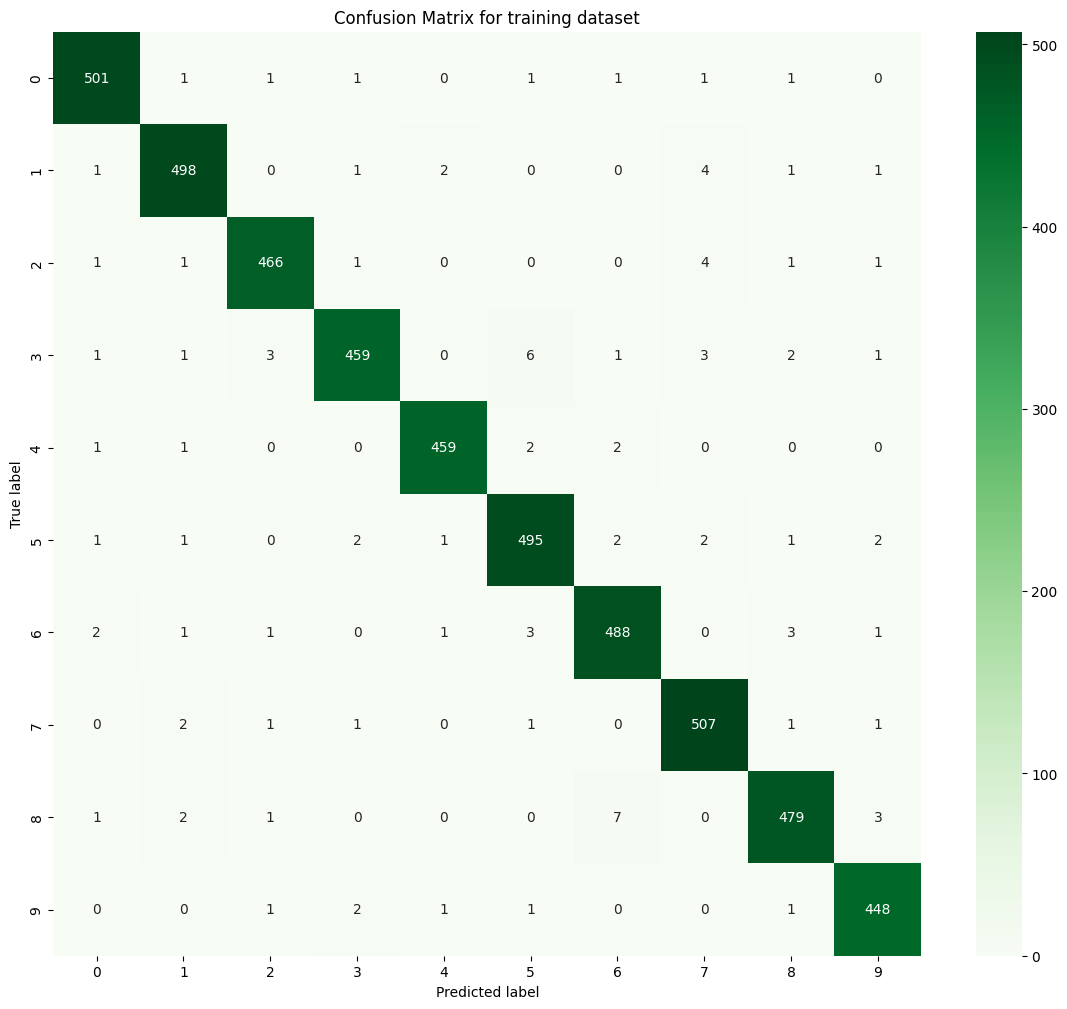

In [39]:
matrix = confusion_matrix(val_ds_y, ans_val_avg_categorical_accuracy)

fig, ax = plt.subplots(figsize=(14, 12))
seaborn.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Модель является одной лучших, среди нами написанных. Она очень хорошо повлияла на наш скор.